Files already downloaded and verified
Files already downloaded and verified
[Group A] Epoch 1/20: PGD Train Loss = 1.7770, Test Loss = 1.8619 | PGD-LM Train Loss = 1.7479, Test Loss = 1.8371
[Group A] Epoch 2/20: PGD Train Loss = 1.6844, Test Loss = 1.9903 | PGD-LM Train Loss = 1.6237, Test Loss = 1.9616
[Group A] Epoch 3/20: PGD Train Loss = 1.6563, Test Loss = 1.8963 | PGD-LM Train Loss = 1.5754, Test Loss = 1.8244
[Group A] Epoch 4/20: PGD Train Loss = 1.6264, Test Loss = 1.8954 | PGD-LM Train Loss = 1.5329, Test Loss = 1.8922
[Group A] Epoch 5/20: PGD Train Loss = 1.5882, Test Loss = 3.0471 | PGD-LM Train Loss = 1.4859, Test Loss = 2.7672
[Group A] Epoch 6/20: PGD Train Loss = 1.5754, Test Loss = 1.9255 | PGD-LM Train Loss = 1.4601, Test Loss = 1.9120
[Group A] Epoch 7/20: PGD Train Loss = 1.5439, Test Loss = 2.5658 | PGD-LM Train Loss = 1.4255, Test Loss = 2.5597
[Group A] Epoch 8/20: PGD Train Loss = 1.5292, Test Loss = 2.2175 | PGD-LM Train Loss = 1.4009, Test Loss = 2.1905
[Gro

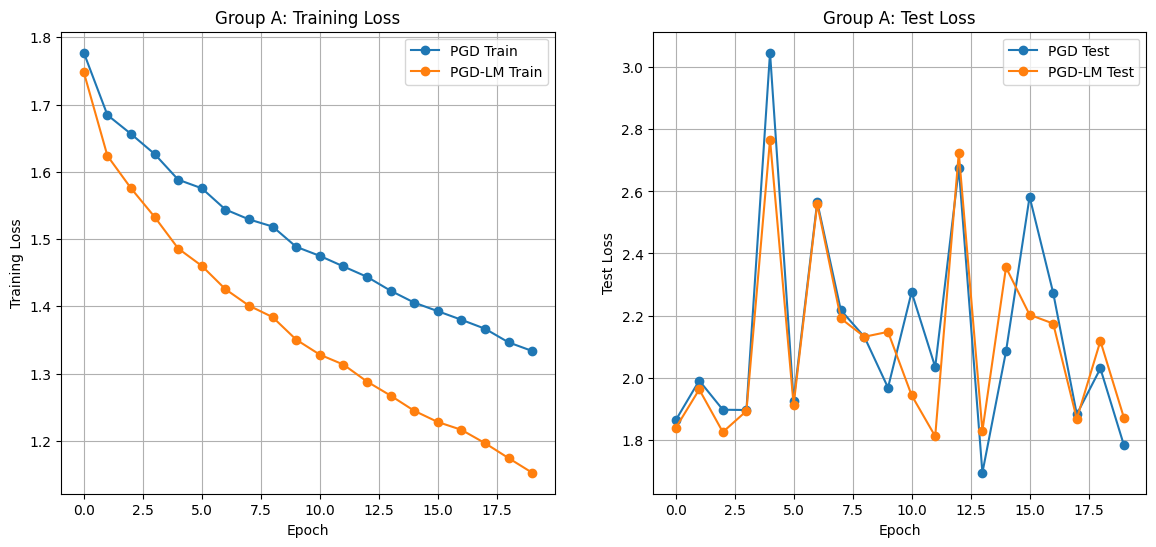

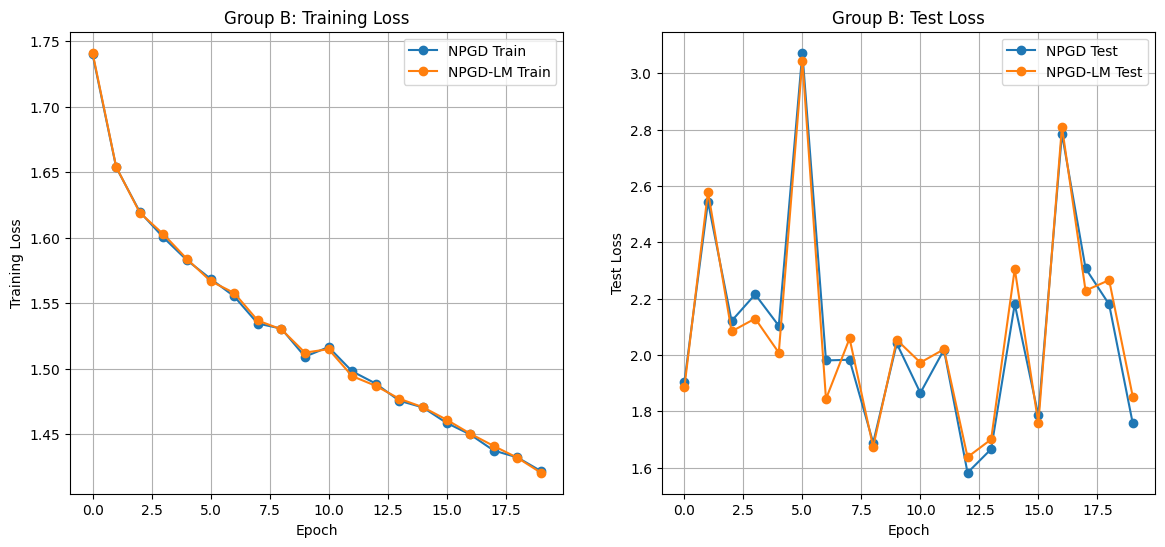

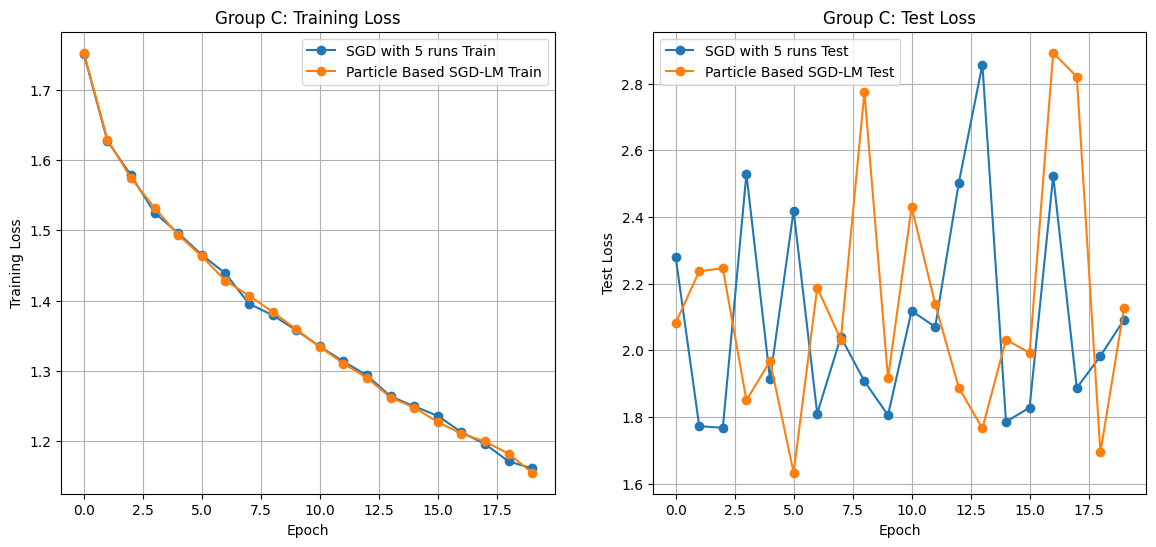

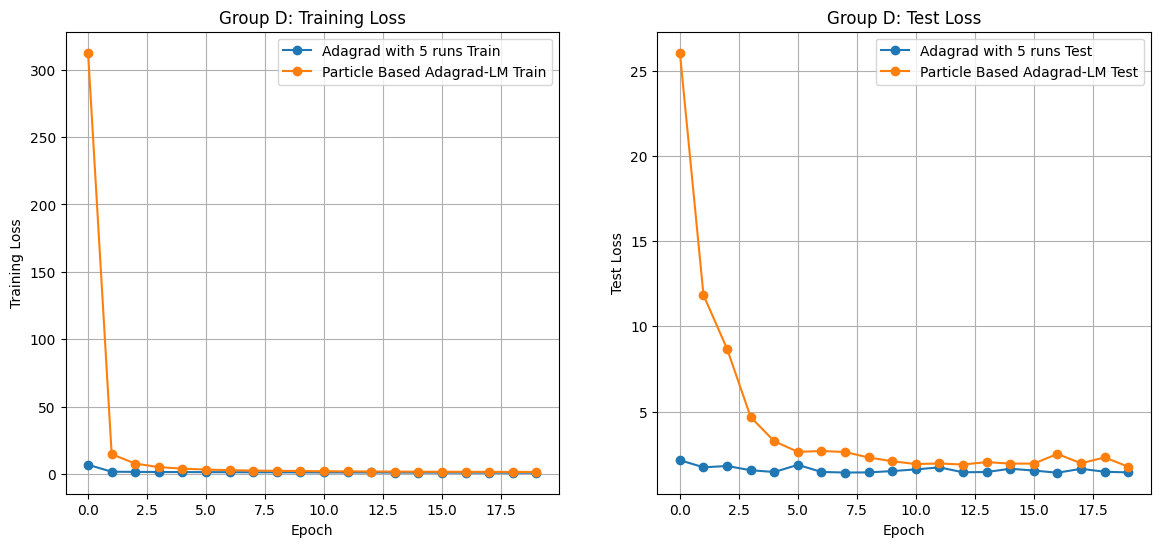


Average Losses:
Group A (PGD) - Train = 1.5007, Test = 2.1404
Group A (PGD-LM) - Train = 1.3698, Test = 2.1058
Group B (NPGD) - Train = 1.5271, Test = 2.0889
Group B (NPGD-LM) - Train = 1.5276, Test = 2.0954
Group C (SGD with 5 runs) - Train = 1.3724, Test = 2.0944
Group C (Particle Based SGD-LM) - Train = 1.3722, Test = 2.1351
Group D (Adagrad with 5 runs) - Train = 1.4101, Test = 1.5907
Group D (Particle Based Adagrad-LM) - Train = 18.6419, Test = 4.3561

Final Test Accuracy:
Group A (PGD): 47.55%, PGD-LM: 46.45%
Group B (NPGD): 47.14%, NPGD-LM : 46.90%
Group C (SGD with 5 runs): 46.09%, Particle Based SGD-LM: 45.74%
Group D (Adagrad with 5 runs): 54.89%, Particle Based Adagrad-LM: 49.32%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import copy
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Using standard CIFAR10 normalization statistics
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader  = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader   = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

 
# ## Model
# %%
num_particles = 5
num_epochs = 20

# %%
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=32*32*3, hidden_dim=128, output_dim=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the 3-channel 32x32 image to a vector of size 3072
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

criterion = nn.CrossEntropyLoss()

# Common initial states for all optimizers
def get_initial_states(num_states):
    base_model = SimpleMLP()
    initial_states = []
    for _ in range(num_states):
        initial_states.append(copy.deepcopy(base_model.state_dict()))
        base_model.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)
    return initial_states

initial_states = get_initial_states(num_particles)

def load_models_from_states(states):
    models = []
    for state in states:
        model = SimpleMLP().to(device)
        model.load_state_dict(state)
        models.append(model)
    return models

def evaluate_loss(models, loader):
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs_sum = 0
            for m in models:
                outputs_sum += m(images)
            outputs_avg = outputs_sum / len(models)
            loss = criterion(outputs_avg, labels).item()
            total_loss += loss * images.size(0)
            total_count += images.size(0)
    return total_loss / total_count

 
# ### Group A Update Functions
# %%
def update_PGD(model, optimizer, images, labels, noise_std=1e-3):
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        for p in model.parameters():
            p.add_(torch.randn_like(p) * noise_std)
    return loss.item()

def update_PGD_LM(model, optimizer, images, labels, iter, c, alpha_init=0.1, decay_factor=0.99, epsilon=1, f_func=lambda x: x):
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward(retain_graph=True)
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm += p.grad.data.norm(2).item() ** 2
    G_t = loss.item()
    alpha_t = alpha_init * (decay_factor ** iter)
    mod_factor = alpha_t * f_func(max(0, G_t - c)) + epsilon
    with torch.no_grad():
        for p in model.parameters():
            if p.grad is not None:
                p.grad.data.div_(mod_factor)
    optimizer.step()
    return loss.item()

 
# ### Group B Update Functions
# %%
def update_NPGD(model, optimizer, images, labels, stepsize, tau=0.001):
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            noise = torch.randn_like(p) * (2 * stepsize * tau)**0.5
            p.data = p.data - stepsize * p.grad.data + noise
    return loss.item()

def update_NPGD_LM(model, optimizer, images, labels, stepsize, iter, c, tau=0.001, alpha_init=0.1, decay_factor=0.99, epsilon=1, f_func=lambda x: x):
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward(retain_graph=True)
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm += p.grad.data.norm(2).item() ** 2
    G_t = loss.item()
    alpha_t = alpha_init * (decay_factor ** iter)
    mod_factor = alpha_t * f_func(max(0, G_t - c)) + epsilon
    with torch.no_grad():
        for p in model.parameters():
            if p.grad is not None:
                scaled_grad = p.grad.data / mod_factor
                noise = torch.randn_like(p) * (2 * stepsize * tau)**0.5
                p.data = p.data - stepsize * scaled_grad + noise
    optimizer.zero_grad() 
    return loss.item()

 
# ### Group C Update Functions
# %%
def update_SGD(model, optimizer, images, labels):
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def update_SGD_LM(model, optimizer, images, labels, iter, c, alpha_init=0.1, decay_factor=0.99, epsilon=1, f_func=lambda x: x):
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward(retain_graph=True)
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm += p.grad.data.norm(2).item() ** 2
    G_t = loss.item()
    alpha_t = alpha_init * (decay_factor ** iter)
    mod_factor = alpha_t * f_func(max(0, G_t - c)) + epsilon
    with torch.no_grad():
        for p in model.parameters():
            if p.grad is not None:
                p.grad.data.div_(mod_factor)
    optimizer.step()
    return loss.item()

 
# ### Group D Update Functions
# %%
def init_adagrad_state(model):
    state = {}
    for p in model.parameters():
        state[id(p)] = torch.zeros_like(p.data)
    return state

def update_adagrad_LM(model, state, images, labels, iter, c, alpha_init=0.1, decay_factor=0.99, epsilon=1, f_func=lambda x: x):
    model.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    total_norm_sq = 0.0
    adjusted_grads = {}
    with torch.no_grad():
        for p in model.parameters():
            if p.grad is not None:
                state[id(p)] += p.grad.data.pow(2)
                adjusted = p.grad.data / (state[id(p)].sqrt() + 1e-8)
                adjusted_grads[id(p)] = adjusted
                total_norm_sq += adjusted.pow(2).sum().item()
    G_t = total_norm_sq ** 0.5
    alpha_t = alpha_init * (decay_factor ** iter)
    mod_factor = alpha_t * f_func(max(0, G_t - c)) + epsilon
    with torch.no_grad():
        for p in model.parameters():
            if p.grad is not None:
                final_grad = adjusted_grads[id(p)] / mod_factor
                p.data.sub_(final_grad)
    model.zero_grad()
    return loss.item()

 
# ## Run Experiment
# %%
def evaluate(models, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs_sum = 0
            for m in models:
                outputs_sum += m(images)
            outputs_avg = outputs_sum / len(models)
            _, predicted = torch.max(outputs_avg, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def run_experiment_A(num_epochs=5, noise_std=1e-3, alpha_init=0.1, decay_factor=0.99, epsilon=1):
    models_A_PGD    = load_models_from_states(initial_states)
    models_A_PGD_LM = load_models_from_states(initial_states)
    
    optim_A_PGD    = [optim.SGD(m.parameters(), lr=0.1) for m in models_A_PGD]
    optim_A_PGD_LM = [optim.SGD(m.parameters(), lr=0.1) for m in models_A_PGD_LM]
    
    global_iter = 0
    train_loss_history = {'PGD': [], 'PGD-LM': []}
    test_loss_history  = {'PGD': [], 'PGD-LM': []}
    
    for epoch in range(num_epochs):
        epoch_losses_PGD = []
        epoch_losses_PGD_LM = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # PGD update (standard noisy update)
            loss_batch = 0.0
            for m, opt in zip(models_A_PGD, optim_A_PGD):
                loss_batch += update_PGD(m, opt, images, labels, noise_std)
            epoch_losses_PGD.append(loss_batch / num_particles)
            # PGD-LM update
            losses = []
            for m in models_A_PGD_LM:
                with torch.no_grad():
                    out = m(images)
                    losses.append(criterion(out, labels).item())
            avg_loss = np.mean(losses)
            loss_batch = 0.0
            for m, opt in zip(models_A_PGD_LM, optim_A_PGD_LM):
                loss_batch += update_PGD_LM(m, opt, images, labels, global_iter, avg_loss,
                                              alpha_init, decay_factor, epsilon)
            epoch_losses_PGD_LM.append(loss_batch / num_particles)
            global_iter += 1
        train_loss_PGD    = np.mean(epoch_losses_PGD)
        train_loss_PGD_LM = np.mean(epoch_losses_PGD_LM)
        train_loss_history['PGD'].append(train_loss_PGD)
        train_loss_history['PGD-LM'].append(train_loss_PGD_LM)
        
        test_loss_PGD    = evaluate_loss(models_A_PGD, test_loader)
        test_loss_PGD_LM = evaluate_loss(models_A_PGD_LM, test_loader)
        test_loss_history['PGD'].append(test_loss_PGD)
        test_loss_history['PGD-LM'].append(test_loss_PGD_LM)
        
        print(f"[Group A] Epoch {epoch+1}/{num_epochs}: PGD Train Loss = {train_loss_PGD:.4f}, Test Loss = {test_loss_PGD:.4f} | "
              f"PGD-LM Train Loss = {train_loss_PGD_LM:.4f}, Test Loss = {test_loss_PGD_LM:.4f}")
    return train_loss_history, test_loss_history, models_A_PGD, models_A_PGD_LM

def run_experiment_B(num_epochs=5, stepsize=0.08, tau=0.01, alpha_init=0.1, decay_factor=0.99, epsilon=1, f_func=lambda x:x):
    models_B_NPGD    = load_models_from_states(initial_states)
    models_B_NPGD_LM = load_models_from_states(initial_states)
    
    optim_B_NPGD    = [optim.SGD(m.parameters(), lr=stepsize) for m in models_B_NPGD]
    optim_B_NPGD_LM = [optim.SGD(m.parameters(), lr=stepsize) for m in models_B_NPGD_LM]
    
    global_iter = 0
    train_loss_history = {'NPGD': [], 'NPGD-LM': []}
    test_loss_history  = {'NPGD': [], 'NPGD-LM': []}
    
    for epoch in range(num_epochs):
        epoch_losses_NPGD = []
        epoch_losses_NPGD_LM = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            loss_batch = 0.0
            for m, opt in zip(models_B_NPGD, optim_B_NPGD):
                loss_batch += update_NPGD(m, opt, images, labels, stepsize, tau)
            epoch_losses_NPGD.append(loss_batch / num_particles)
            
            losses = []
            for m in models_B_NPGD_LM:
                with torch.no_grad():
                    out = m(images)
                    losses.append(criterion(out, labels).item())
            avg_loss = np.mean(losses)
            loss_batch = 0.0
            for m, opt in zip(models_B_NPGD_LM, optim_B_NPGD_LM):
                loss_batch += update_NPGD_LM(m, opt, images, labels, stepsize, global_iter, avg_loss, tau, alpha_init, decay_factor, epsilon, f_func)
            epoch_losses_NPGD_LM.append(loss_batch / num_particles)
            global_iter += 1
        train_loss_NPGD    = np.mean(epoch_losses_NPGD)
        train_loss_NPGD_LM = np.mean(epoch_losses_NPGD_LM)
        train_loss_history['NPGD'].append(train_loss_NPGD)
        train_loss_history['NPGD-LM'].append(train_loss_NPGD_LM)
        
        test_loss_NPGD    = evaluate_loss(models_B_NPGD, test_loader)
        test_loss_NPGD_LM = evaluate_loss(models_B_NPGD_LM, test_loader)
        test_loss_history['NPGD'].append(test_loss_NPGD)
        test_loss_history['NPGD-LM'].append(test_loss_NPGD_LM)
        
        print(f"[Group B] Epoch {epoch+1}/{num_epochs}:  NPGD Train Loss = {train_loss_NPGD:.4f}, Test Loss = {test_loss_NPGD:.4f} | "
              f" NPGD-LM Train Loss = {train_loss_NPGD_LM:.4f}, Test Loss = {test_loss_NPGD_LM:.4f}")
    return train_loss_history, test_loss_history, models_B_NPGD, models_B_NPGD_LM

def run_experiment_C(num_epochs=5, alpha_init=0.1, decay_factor=0.99, epsilon=1):
    models_C_ind = load_models_from_states(initial_states)
    optim_C_ind = [optim.SGD(m.parameters(), lr=0.1) for m in models_C_ind]
    train_loss_history_ind = []
    test_loss_history_ind = []
    for epoch in range(num_epochs):
        epoch_losses = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            batch_loss = 0.0
            for m, opt in zip(models_C_ind, optim_C_ind):
                batch_loss += update_SGD(m, opt, images, labels)
            epoch_losses.append(batch_loss / num_particles)
        avg_epoch_loss = np.mean(epoch_losses)
        train_loss_history_ind.append(avg_epoch_loss)
        test_loss_history_ind.append(evaluate_loss(models_C_ind, test_loader))
        print(f"[Group C] Epoch {epoch+1}/{num_epochs} SGD with 5 runs: Train Loss = {avg_epoch_loss:.4f}, Test Loss = {test_loss_history_ind[-1]:.4f}")
    
    models_C_lm = load_models_from_states(initial_states)
    optim_C_lm = [optim.SGD(m.parameters(), lr=0.1) for m in models_C_lm]
    global_iter = 0
    train_loss_history_lm = []
    test_loss_history_lm = []
    for epoch in range(num_epochs):
        epoch_losses = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            losses = []
            for m in models_C_lm:
                with torch.no_grad():
                    out = m(images)
                    losses.append(criterion(out, labels).item())
            avg_loss = np.mean(losses)
            batch_loss = 0.0
            for m, opt in zip(models_C_lm, optim_C_lm):
                batch_loss += update_SGD_LM(m, opt, images, labels, global_iter, avg_loss,
                                              alpha_init, decay_factor, epsilon)
            epoch_losses.append(batch_loss / num_particles)
            global_iter += 1
        avg_epoch_loss = np.mean(epoch_losses)
        train_loss_history_lm.append(avg_epoch_loss)
        test_loss_history_lm.append(evaluate_loss(models_C_lm, test_loader))
        print(f"[Group C] Epoch {epoch+1}/{num_epochs} Particle Based SGD-LM: Train Loss = {avg_epoch_loss:.4f}, Test Loss = {test_loss_history_lm[-1]:.4f}")
    return train_loss_history_ind, test_loss_history_ind, train_loss_history_lm, test_loss_history_lm, models_C_ind, models_C_lm

def run_experiment_D(num_epochs=5, alpha_init=0.1, decay_factor=0.99, epsilon=1, f_func=lambda x: x):
    models_D_ind = load_models_from_states(initial_states)
    optim_D_ind = [optim.Adagrad(m.parameters(), lr=0.1) for m in models_D_ind]
    train_loss_history_ind = []
    test_loss_history_ind = []
    for epoch in range(num_epochs):
        epoch_losses = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            batch_loss = 0.0
            for m, opt in zip(models_D_ind, optim_D_ind):
                batch_loss += update_SGD(m, opt, images, labels)
            epoch_losses.append(batch_loss / num_particles)
        avg_epoch_loss = np.mean(epoch_losses)
        train_loss_history_ind.append(avg_epoch_loss)
        test_loss_history_ind.append(evaluate_loss(models_D_ind, test_loader))
        print(f"[Group D] Epoch {epoch+1}/{num_epochs} Adagrad with 5 runs: Train Loss = {avg_epoch_loss:.4f}, Test Loss = {test_loss_history_ind[-1]:.4f}")
    
    models_D_lm = load_models_from_states(initial_states)
    adagrad_states = [init_adagrad_state(m) for m in models_D_lm]
    global_iter = 0
    train_loss_history_lm = []
    test_loss_history_lm = []
    for epoch in range(num_epochs):
        epoch_losses = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            losses = []
            for m in models_D_lm:
                with torch.no_grad():
                    out = m(images)
                    losses.append(criterion(out, labels).item())
            avg_loss = np.mean(losses)
            batch_loss = 0.0
            for m, state in zip(models_D_lm, adagrad_states):
                batch_loss += update_adagrad_LM(m, state, images, labels, global_iter, avg_loss,
                                                  alpha_init, decay_factor, epsilon, f_func=lambda x: x)
            epoch_losses.append(batch_loss / num_particles)
            global_iter += 1
        avg_epoch_loss = np.mean(epoch_losses)
        train_loss_history_lm.append(avg_epoch_loss)
        test_loss_history_lm.append(evaluate_loss(models_D_lm, test_loader))
        print(f"[Group D] Epoch {epoch+1}/{num_epochs} Particle Based Adagrad-LM: Train Loss = {avg_epoch_loss:.4f}, Test Loss = {test_loss_history_lm[-1]:.4f}")
    return train_loss_history_ind, test_loss_history_ind, train_loss_history_lm, test_loss_history_lm, models_D_ind, models_D_lm

# %%
(train_loss_A, test_loss_A, models_A_PGD, models_A_PGD_LM) = run_experiment_A(num_epochs=num_epochs)
(train_loss_B, test_loss_B, models_B_NPGD, models_B_NPGD_LM) = run_experiment_B(num_epochs=num_epochs, stepsize=0.08, tau=1e-5)
(loss_B_ind_train, loss_B_ind_test, loss_B_lm_train, loss_B_lm_test, models_C_ind, models_C_lm) = run_experiment_C(num_epochs=num_epochs)
(loss_C_ind_train, loss_C_ind_test, loss_C_lm_train, loss_C_lm_test, models_D_ind, models_D_lm) = run_experiment_D(num_epochs=num_epochs)

 
# ## Visualization and Result Analysis
# %%
# Group A
figA, (axA1, axA2) = plt.subplots(1, 2, figsize=(14,6))
axA1.plot(train_loss_A['PGD'], label="PGD Train", marker='o')
axA1.plot(train_loss_A['PGD-LM'], label="PGD-LM Train", marker='o')
axA1.set_xlabel("Epoch")
axA1.set_ylabel("Training Loss")
axA1.set_title("Group A: Training Loss")
axA1.legend(); axA1.grid(True)
axA2.plot(test_loss_A['PGD'], label="PGD Test", marker='o')
axA2.plot(test_loss_A['PGD-LM'], label="PGD-LM Test", marker='o')
axA2.set_xlabel("Epoch")
axA2.set_ylabel("Test Loss")
axA2.set_title("Group A: Test Loss")
axA2.legend(); axA2.grid(True)
plt.show()

# Group B
figB, (axB1, axB2) = plt.subplots(1, 2, figsize=(14,6))
axB1.plot(train_loss_B['NPGD'], label="NPGD Train", marker='o')
axB1.plot(train_loss_B['NPGD-LM'], label="NPGD-LM Train", marker='o')
axB1.set_xlabel("Epoch")
axB1.set_ylabel("Training Loss")
axB1.set_title("Group B: Training Loss")
axB1.legend(); axB1.grid(True)
axB2.plot(test_loss_B['NPGD'], label="NPGD Test", marker='o')
axB2.plot(test_loss_B['NPGD-LM'], label="NPGD-LM Test", marker='o')
axB2.set_xlabel("Epoch")
axB2.set_ylabel("Test Loss")
axB2.set_title("Group B: Test Loss")
axB2.legend(); axB2.grid(True)
plt.show()

# Group C
figC, (axC1, axC2) = plt.subplots(1, 2, figsize=(14,6))
axC1.plot(loss_B_ind_train, label="SGD with 5 runs Train", marker='o')
axC1.plot(loss_B_lm_train, label="Particle Based SGD-LM Train", marker='o')
axC1.set_xlabel("Epoch")
axC1.set_ylabel("Training Loss")
axC1.set_title("Group C: Training Loss")
axC1.legend(); axC1.grid(True)
axC2.plot(loss_B_ind_test, label="SGD with 5 runs Test", marker='o')
axC2.plot(loss_B_lm_test, label="Particle Based SGD-LM Test", marker='o')
axC2.set_xlabel("Epoch")
axC2.set_ylabel("Test Loss")
axC2.set_title("Group C: Test Loss")
axC2.legend(); axC2.grid(True)
plt.show()

# Group D
figD, (axD1, axD2) = plt.subplots(1, 2, figsize=(14,6))
axD1.plot(loss_C_ind_train, label="Adagrad with 5 runs Train", marker='o')
axD1.plot(loss_C_lm_train, label="Particle Based Adagrad-LM Train", marker='o')
axD1.set_xlabel("Epoch")
axD1.set_ylabel("Training Loss")
axD1.set_title("Group D: Training Loss")
axD1.legend(); axD1.grid(True)
axD2.plot(loss_C_ind_test, label="Adagrad with 5 runs Test", marker='o')
axD2.plot(loss_C_lm_test, label="Particle Based Adagrad-LM Test", marker='o')
axD2.set_xlabel("Epoch")
axD2.set_ylabel("Test Loss")
axD2.set_title("Group D: Test Loss")
axD2.legend(); axD2.grid(True)
plt.show()

# Results summary
avg_train_loss_A = {
    'PGD': np.mean(train_loss_A['PGD']),
    'PGD-LM': np.mean(train_loss_A['PGD-LM'])
}
avg_test_loss_A = {
    'PGD': np.mean(test_loss_A['PGD']),
    'PGD-LM': np.mean(test_loss_A['PGD-LM'])
}
avg_train_loss_B_ind = np.mean(train_loss_B['NPGD'])
avg_test_loss_B_ind  = np.mean(test_loss_B['NPGD'])
avg_train_loss_B_lm  = np.mean(train_loss_B['NPGD-LM'])
avg_test_loss_B_lm   = np.mean(test_loss_B['NPGD-LM'])
avg_train_loss_C_ind = np.mean(loss_B_ind_train)
avg_test_loss_C_ind  = np.mean(loss_B_ind_test)
avg_train_loss_C_lm  = np.mean(loss_B_lm_train)
avg_test_loss_C_lm   = np.mean(loss_B_lm_test)
avg_train_loss_D_ind = np.mean(loss_C_ind_train)
avg_test_loss_D_ind  = np.mean(loss_C_ind_test)
avg_train_loss_D_lm  = np.mean(loss_C_lm_train)
avg_test_loss_D_lm   = np.mean(loss_C_lm_test)

print("\nAverage Losses:")
print(f"Group A (PGD) - Train = {avg_train_loss_A['PGD']:.4f}, Test = {avg_test_loss_A['PGD']:.4f}")
print(f"Group A (PGD-LM) - Train = {avg_train_loss_A['PGD-LM']:.4f}, Test = {avg_test_loss_A['PGD-LM']:.4f}")
print(f"Group B (NPGD) - Train = {avg_train_loss_B_ind:.4f}, Test = {avg_test_loss_B_ind:.4f}")
print(f"Group B (NPGD-LM) - Train = {avg_train_loss_B_lm:.4f}, Test = {avg_test_loss_B_lm:.4f}")
print(f"Group C (SGD with 5 runs) - Train = {avg_train_loss_C_ind:.4f}, Test = {avg_test_loss_C_ind:.4f}")
print(f"Group C (Particle Based SGD-LM) - Train = {avg_train_loss_C_lm:.4f}, Test = {avg_test_loss_C_lm:.4f}")
print(f"Group D (Adagrad with 5 runs) - Train = {avg_train_loss_D_ind:.4f}, Test = {avg_test_loss_D_ind:.4f}")
print(f"Group D (Particle Based Adagrad-LM) - Train = {avg_train_loss_D_lm:.4f}, Test = {avg_test_loss_D_lm:.4f}")

def eval_ensemble(models, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs_sum = 0
            for m in models:
                outputs_sum += m(images)
            outputs_avg = outputs_sum / len(models)
            _, predicted = torch.max(outputs_avg, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

acc_A_PGD    = evaluate(models_A_PGD, test_loader)
acc_A_PGD_LM = evaluate(models_A_PGD_LM, test_loader)
acc_B_NPGD    = evaluate(models_B_NPGD, test_loader)
acc_B_NPGD_LM = evaluate(models_B_NPGD_LM, test_loader)
acc_C_SGD     = evaluate(models_C_ind, test_loader)
acc_C_SGD_LM  = evaluate(models_C_lm, test_loader)
acc_D_Adagrad     = evaluate(models_D_ind, test_loader)
acc_D_Adagrad_LM  = evaluate(models_D_lm, test_loader)

print("\nFinal Test Accuracy:")
print(f"Group A (PGD): {acc_A_PGD:.2f}%, PGD-LM: {acc_A_PGD_LM:.2f}%")
print(f"Group B (NPGD): {acc_B_NPGD:.2f}%, NPGD-LM : {acc_B_NPGD_LM:.2f}%")
print(f"Group C (SGD with 5 runs): {acc_C_SGD:.2f}%, Particle Based SGD-LM: {acc_C_SGD_LM:.2f}%")
print(f"Group D (Adagrad with 5 runs): {acc_D_Adagrad:.2f}%, Particle Based Adagrad-LM: {acc_D_Adagrad_LM:.2f}%")
